# Reconstructed Samples

This notebook illustrates the reconstruced samples by GMI, KED-MI, or PLG-MI, as presented at the Figure 2, 8, 9, 10, and 11 in our paper: https://arxiv.org/abs/2411.08460.

## Prerequisites

Conducted the Model Training and the Model Inversion Attacks to produce reconstructed samples, as instructed in [README.md](https://github.com/ntuaislab/Trap-MID/blob/main/README.md).

In [3]:
import os
from pathlib import Path

import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import pandas as pd

In [ ]:
class PrivateCeleba(torch.utils.data.Dataset):
    def __init__(self,
                 root='datasets/celeba',
                 file_path=['data/celeba_trainset.txt'],
                 img_root='datasets/celeba/img_align_celeba', transform=None):
        super(PrivateCeleba, self).__init__()
        self.root = root
        self.file_path = file_path
        self.img_root = img_root
        self.transform = transform
        self.images = []
        self.identity = []
        name_list = []

        for file_path in self.file_path:
            f = open(file_path, "r")
            for line in f.readlines():
                img_name, iden = (item.strip() for item in line.split())
                name_list.append(img_name)
                self.images.append(os.path.join(self.img_root, img_name))
                self.identity.append(int(iden))
        self.identity = torch.as_tensor(self.identity)

        attr = pd.read_csv(os.path.join(self.root, "list_attr_celeba.txt"), delim_whitespace=True, header=1)
        self.attr_names = list(attr.columns)

        attr = torch.as_tensor(attr.loc[name_list, :].values)
        attr = torch.div(attr + 1, 2, rounding_mode='floor') # map from {-1, 1} to {0, 1}
        self.attr = attr

    def __getitem__(self, index):
        img_path = self.images[index]
        img = Image.open(img_path)
        if self.transform != None:
            img = self.transform(img)

        return img, self.attr[index, :]

    def __len__(self):
        return len(self.images)

In [ ]:
re_size = 64
crop_size = 108
offset_height = (218 - crop_size) // 2
offset_width = (178 - crop_size) // 2
crop = lambda x: x[:, offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]
celeba_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop),
    transforms.ToPILImage(),
    transforms.Resize((re_size, re_size)),
])
dataset = PrivateCeleba(root='<PATH_TO_CELEBA_ROOT>',
                        file_path=['<PATH_TO_TRAIN_SET>'],
                        img_root='<PATH_TO_IMAGE_ROOT',
                        transform=celeba_transform
                        )
len(dataset), len(set(dataset.identity.tolist()))

(27018, 1000)

In [ ]:
root = Path('<PATH_TO_ATTACK_RESULT>')
recovered_root = {
    "Unprotected": '<PATH_TO_SUBFOLDER_OF_UNPROTECTED>',
    "MID": '<PATH_TO_SUBFOLDER_OF_MID>',
    "BiDO": '<PATH_TO_SUBFOLDER_OF_BIDO>',
    "NegLS": '<PATH_TO_SUBFOLDER_OF_NEGLS>',
    "Trap-MID": "<PATH_TO_SUBFOLDER_OF_TRAP-MID>",
    "Trap-MID + NegLS": "<PATH_TO_SUBFOLDER_OF_TRAP-MID-NEGLS>",
}
recovered_root = {k: root / v for k, v in recovered_root.items()}

In [7]:
recovered_path = {
    k: v / 'all_imgs'
    for k, v in recovered_root.items()
}

raw_recovered = {
    k: ImageFolder(
        root=root,
    )
    for k, root in recovered_path.items()

}
for k in raw_recovered.keys():
    raw_recovered[k].targets = torch.as_tensor([int(raw_recovered[k].classes[t]) for t in raw_recovered[k].targets])
{k: (len(v), len(v.classes)) for k, v in raw_recovered.items()}

{'Unprotected': (5000, 1000),
 'MID': (5000, 1000),
 'BiDO': (5000, 1000),
 'NegLS': (5000, 1000),
 'Ours': (5000, 1000),
 'Trap-MID + NegLS': (5000, 1000)}

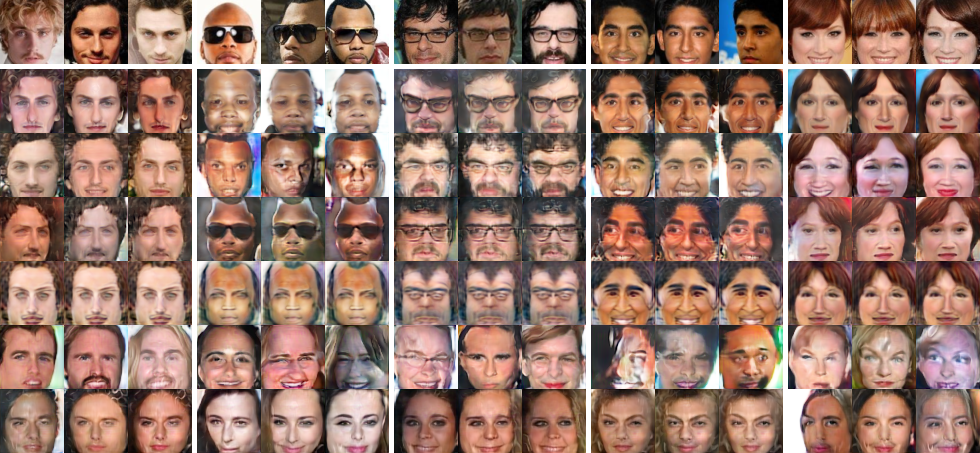

In [ ]:
indices = [4, 678, 951, 533, 599]
size = 64
margin = 5
m = 1 + len(raw_recovered)
n = min(len(indices), 6)
cnt = 3
img = Image.new('RGB', size=(size*n*cnt + margin*(n-1), size*m + margin), color='white')

offset = 0

# Ground truth
for i, iden in enumerate(indices[:n]):
    gt_indices = torch.where(dataset.identity == iden)[0][:cnt]
    for j, idx in enumerate(gt_indices):
        img.paste(dataset[idx][0], (size*(i*cnt) + margin*i + size*j, offset))
offset += margin

for i, iden in enumerate(indices[:n]):
    for k, key in enumerate(['Unprotected', 'MID', 'BiDO', 'NegLS', 'Trap-MID', 'Trap-MID + NegLS'], 1):
        syn_indices = torch.where(raw_recovered[key].targets == iden)[0][:cnt]
        for j, idx in enumerate(syn_indices):
            img.paste(raw_recovered[key][idx][0], (size*(i*cnt) + margin*i + size*j, offset+size*k))

img